# Prediksi Keberhasilan Telemarketing Bank dengan *Gradient Boosting*
---

## Latar Belakang Bisnis & Pernyataan Masalah
Dalam industri perbankan yang kompetitif, kampanye pemasaran langsung (*direct marketing*) melalui telepon masih menjadi strategi utama. Namun, strategi ini seringkali tidak efisien dan mengganggu nasabah jika tidak ditargetkan dengan tepat.

Mengacu pada riset **Moro et al. (2014)**, keberhasilan telemarketing pasca-krisis finansial sangat dipengaruhi oleh indikator makro ekonomi dan profil nasabah. Masalah utama yang dihadapi adalah:
* **Biaya Operasional:** Menelepon setiap nasabah memakan biaya (waktu agen & biaya telepon).
* **Efisiensi:** *Conversion rate* yang rendah jika menargetkan nasabah secara acak.
* **Data Imbalance:** Jumlah nasabah yang setuju membuka deposito jauh lebih sedikit dibandingkan yang menolak, membuat model bias.

## Tujuan Teknis
Proyek ini membangun *End-to-End Machine Learning Pipeline* untuk memprediksi nasabah yang berpotensi membuka deposito berjangka (*Term Deposit*). Pendekatan yang digunakan:
1.  **Robust Preprocessing:** Menangani data kategorikal dan numerik secara otomatis.
2.  **XGBoost Classifier:** Algoritma *Gradient Boosting* yang canggih untuk menangani pola non-linear.
3.  **Hyperparameter Tuning dengan Optuna:** Menggunakan optimasi *Bayesian* untuk menemukan parameter terbaik, jauh lebih efisien daripada *GridSearch*.
4.  **Probability Calibration:** Memastikan skor probabilitas model dapat dipercaya (misal: skor 0.7 benar-benar berarti peluang 70%).
5.  **Profit Maximization:** Menentukan *threshold* keputusan bukan berdasarkan F1-Score semata, melainkan simulasi keuntungan finansial.

In [1]:
# Standard Library & Utilities
import warnings
import joblib
import numpy as np
import pandas as pd

# Visualization
# Digunakan untuk eksplorasi data dan analisis performa model
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models & Tuning
import optuna  # Framework optimasi hyperparameter otomatis berbasis Bayesian (lebih cepat dari GridSearch)
import shap    # Library Explainable AI (XAI) untuk interpretasi model (Global & Local Importance)
from xgboost import XGBClassifier # Algoritma Gradient Boosting yang efisien dan scalable

# Scikit-Learn Ecosystem
# Preprocessing & Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

# Model Selection & Calibration
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV # Penting: Mengubah skor mentah model menjadi probabilitas yang terkalibrasi

# Metrics
from sklearn.metrics import (
    auc,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# Configuration
# Mengatur tampilan visualisasi agar standar dan rapi
sns.set_style('whitegrid')
warnings.filterwarnings('ignore') # Mengabaikan warning agar output notebook lebih bersih

print("Library berhasil diimport")

c:\Users\Alls\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Library berhasil diimport


## 1. Data Cleaning & Exploration
Tahap ini memuat dataset dan melakukan pembersihan awal yang selanjutnya akan dieksplorasi untuk mendapatkan gambaran setiap fitur.

**Penting - Pencegahan *Data Leakage*:**
Sesuai rekomendasi *best practice* dan paper Moro et al., variabel **`duration` (durasi telepon)** harus dihapus sebelum pemodelan.
* **Alasan:** Durasi telepon tidak diketahui *sebelum* panggilan dilakukan. Jika durasi > 0, artinya panggilan sudah terjadi dan target (y) sudah diketahui. Menggunakan variabel ini untuk prediksi masa depan adalah kesalahan fatal.

In [2]:
# Memuat dataset dengan separator ';' sesuai format asli UCI Repository
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Pemeriksaan Awal
print("Jumlah data 'unknown' dari kategorikal:", df.apply(lambda col: col.astype(str).str.contains('unknown', na=False)).sum().sum())
print("Jumlah data kosong:", df.isnull().sum().sum(), "& Jumlah data duplikat:", df.duplicated().sum())

# Cleaning Pipeline
df = (df
    .rename(columns=str.strip) # Membersihkan spasi pada nama kolom
    .replace('unknown', np.nan) # Mengubah string 'unknown' menjadi NaN agar bisa diimputasi
    .assign(y=lambda x: x['y'].map({'yes': 1, 'no': 0})) # Encoding target: 1 untuk Deposit, 0 untuk Tidak
    .drop(columns=['duration'], errors='ignore') # Hapus duration untuk cegah leakage
    .drop_duplicates() # Hapus data duplikat
    .reset_index(drop=True)
)

# Menampilkan data teratas untuk verifikasi
df.head()

Jumlah data 'unknown' dari kategorikal: 12718
Jumlah data kosong: 0 & Jumlah data duplikat: 12


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


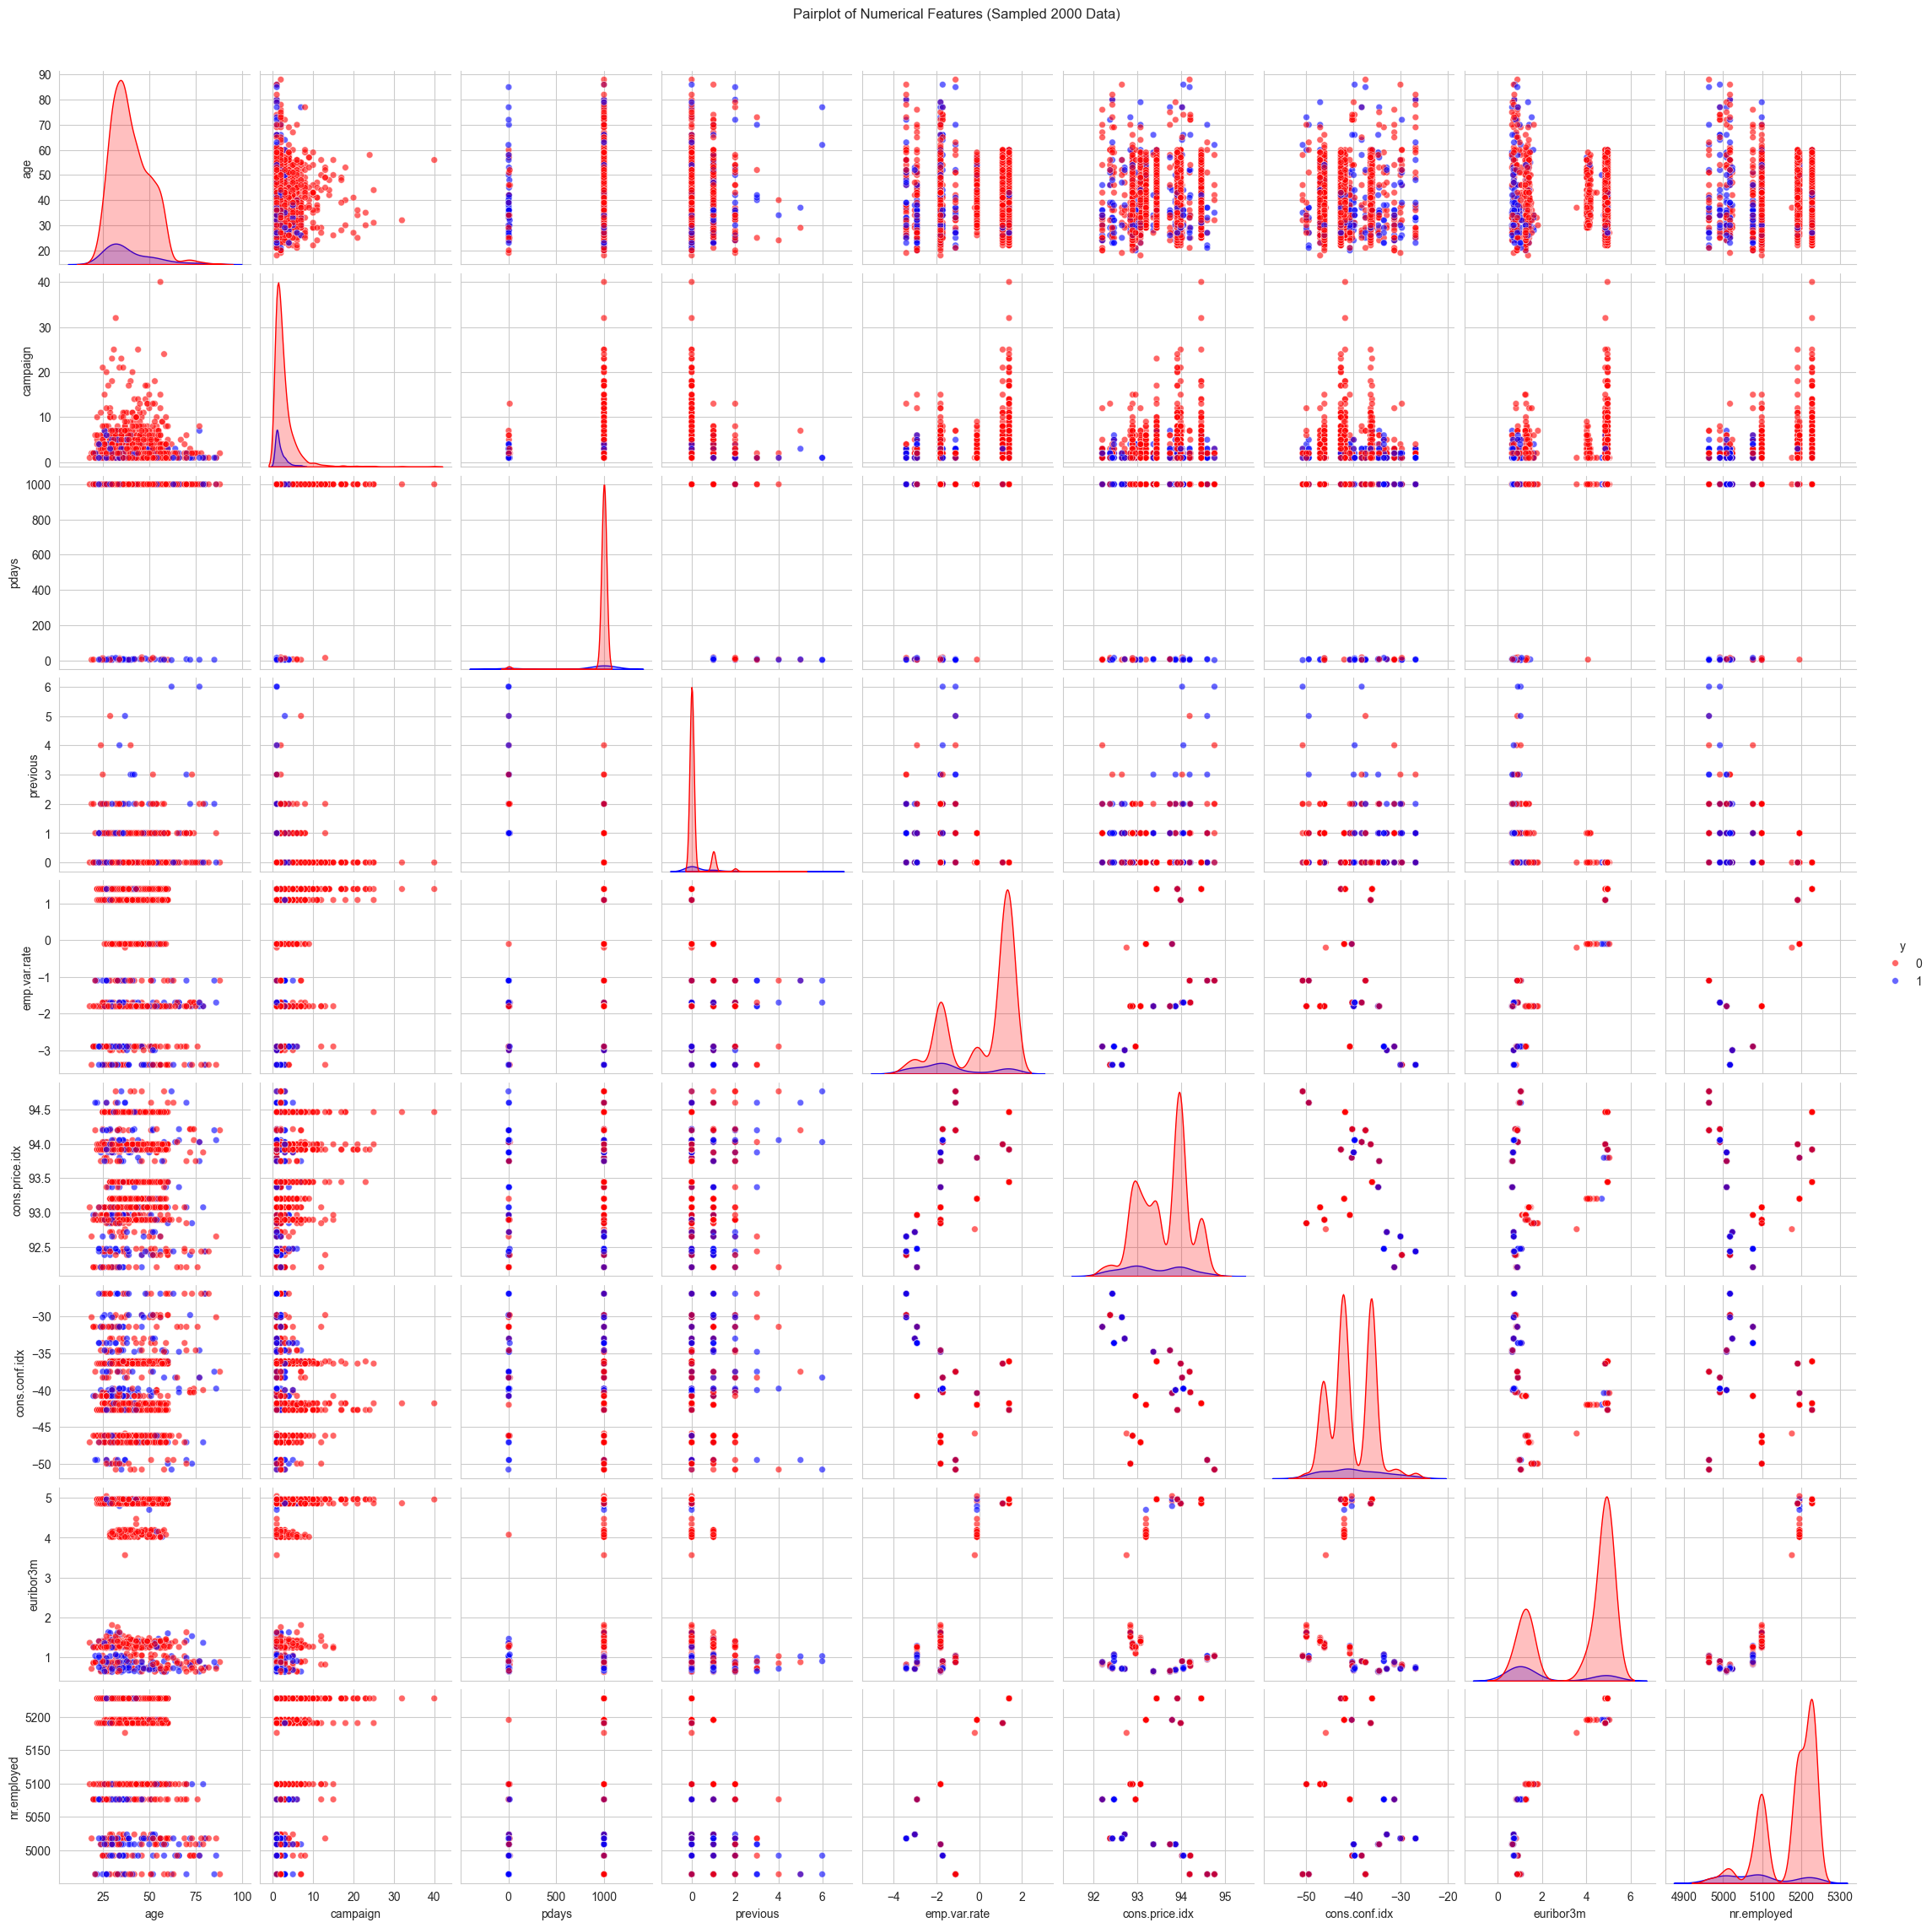

In [3]:
# Visualisasi Distribusi Fitur Numerik
# Tujuan: Melihat sebaran data dan korelasi antar fitur numerik terhadap target 'y'.

# Pilih kolom numerik + target
cols_to_plot = df.select_dtypes(include=[np.number]).columns.tolist()

# Pastikan target 'y' masuk dalam plot
if 'y' not in cols_to_plot and 'y' in df.columns:
    cols_to_plot.append('y')

# Lakukan Sampling (untuk efisiensi)
# Mengambil 2000 data acak saja agar plotting cepat dan tidak "benyek" (overplotting)
df_sample = df[cols_to_plot].sample(n=2000, random_state=42)

# Plotting Pairplot
sns.pairplot(df_sample, 
             hue='y', # Membedakan warna berdasarkan target (Deposit/Tidak)
             diag_kind='kde', # Menggunakan Kernel Density Estimate di diagonal untuk melihat bentuk distribusi
             plot_kws={'alpha': 0.6, 's': 30}, # Transparansi dan ukuran titik
             palette={0: 'red', 1: 'blue'}) # Merah=No, Biru=Yes

plt.suptitle('Pairplot of Numerical Features (Sampled 2000 Data)', y=1.02)
plt.show()

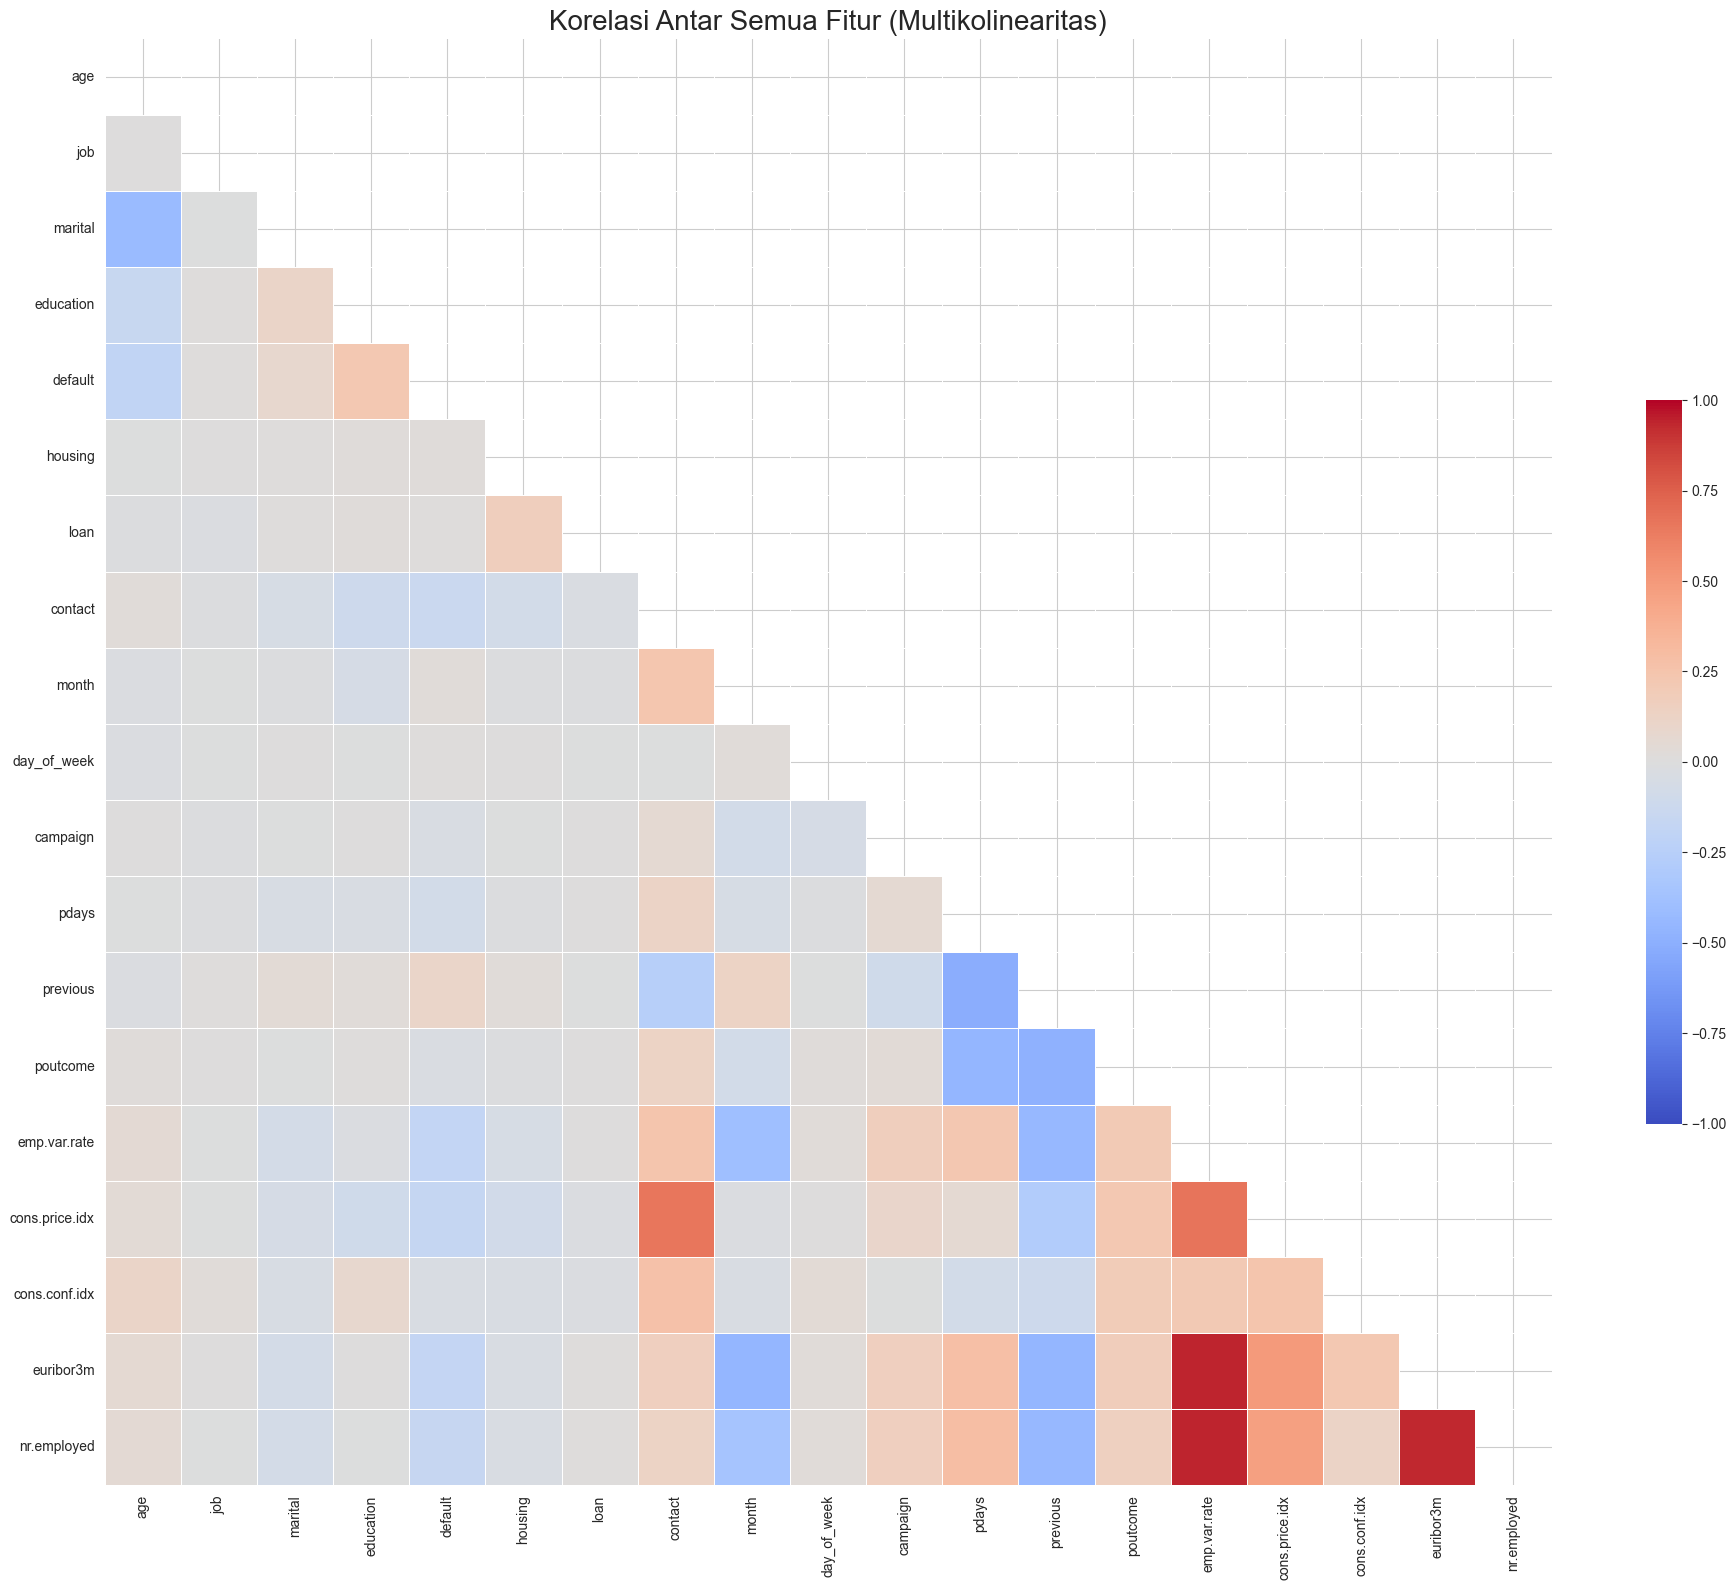

In [4]:
# Visualisasi Korelasi Antar Semua Fitur
# Buat salinan data agar data asli tidak berubah
df_all_corr = df.copy()

# Hapus kolom target 'y' karena hanya akan fokus antar fitur saja
if 'y' in df_all_corr.columns:
    df_all_corr = df_all_corr.drop(columns=['y'])

# Ubah fitur Kategorikal menjadi Angka (Encoding Sederhana)
# Ini diperlukan agar bisa dihitung korelasinya dalam satu matriks
for col in df_all_corr.select_dtypes(include=['object']).columns:
    df_all_corr[col] = df_all_corr[col].astype('category').cat.codes

# Hitung Matriks Korelasi (Pearson & Spearman bisa digunakan, default Pearson)
# Gunakan method='spearman' karena lebih tangguh untuk data ordinal/kategorikal
correlation_matrix = df_all_corr.corr(method='spearman')

# Buat Visualisasi Heatmap
plt.figure(figsize=(20, 16))

# Masking bagian atas segitiga agar grafik lebih bersih
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Gambar Heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            cmap='coolwarm', 
            vmax=1, 
            vmin=-1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=False) # Annot dimatikan agar tidak terlalu penuh angkanya

plt.title('Korelasi Antar Semua Fitur (Multikolinearitas)', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

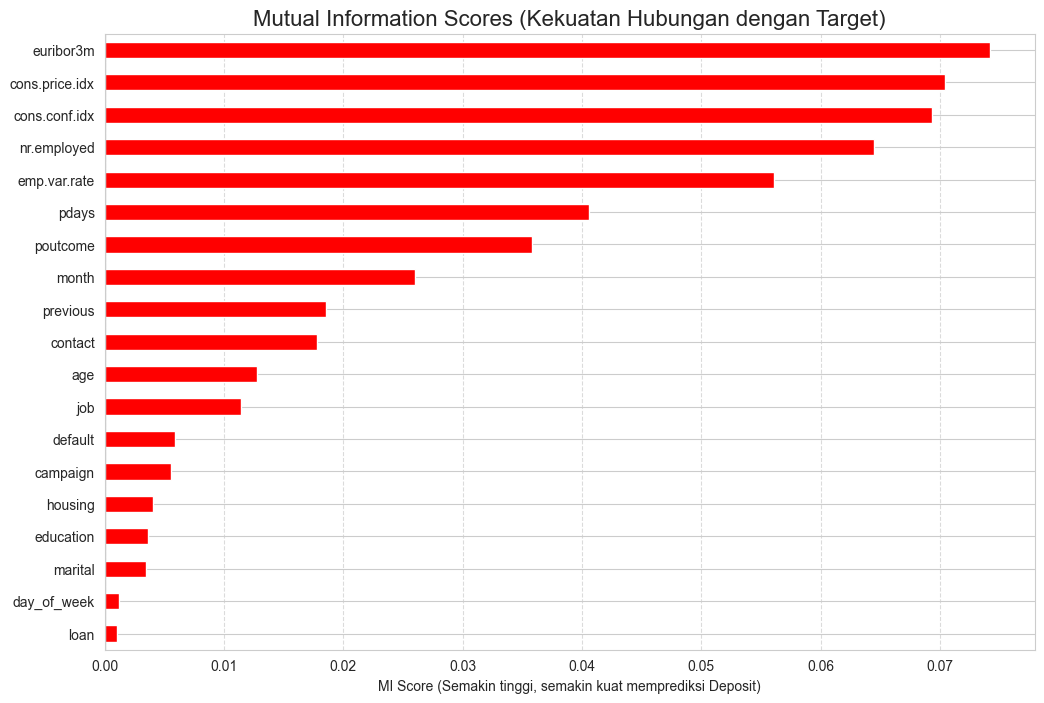

In [5]:
# Visualisasi MI untuk Melihat Kekuatan Hubungan dengan Target
# Siapkan Data Baru khusus untuk MI agar aman
df_mi = df.copy()

# Pastikan target 'y' sudah numerik (0/1)
if df_mi['y'].dtype == 'object':
    df_mi['y'] = df_mi['y'].map({'yes': 1, 'no': 0})

# Encode semua fitur kategorikal menjadi angka
for col in df_mi.select_dtypes(include=['object']).columns:
    df_mi[col] = df_mi[col].astype('category').cat.codes

# Pisahkan X (Fitur) dan y (Target)
X_mi = df_mi.drop(columns=['y'])
y_mi = df_mi['y']

# Pastikan tidak ada NaN (isi dengan 0 agar tidak error)
X_mi = X_mi.fillna(0)

# Hitung Mutual Information
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)

# Visualisasi Hasil
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
mi_series.plot(kind='barh', color='red')
plt.title("Mutual Information Scores (Kekuatan Hubungan dengan Target)", fontsize=16)
plt.xlabel("MI Score (Semakin tinggi, semakin kuat memprediksi Deposit)")
plt.axvline(x=0, color='black', linestyle='-')
plt.gca().invert_yaxis() # Fitur terpenting di paling atas
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## 2. Feature Engineering & Preprocessing Pipeline
Tahap ini mengubah data mentah menjadi format yang dapat dipahami oleh algoritma *Machine Learning*. Kami menggunakan pendekatan **Scikit-Learn Pipeline** untuk menjamin reprodukilitas dan mencegah *data leakage*.

**Strategi Transformasi:**
1.  **Fitur Numerik (Numerical Features):**
    * **Imputasi:** Mengisi nilai kosong (jika ada) dengan *median* untuk menjaga distribusi data dari outlier.
    * **Scaling:** Menggunakan `StandardScaler` untuk menstandarisasi fitur.

    *Hal ini penting agar algoritma tidak bias terhadap fitur dengan skala angka yang besar (misal: 'euribor3m' vs 'age').*

2.  **Fitur Kategorikal (Categorical Features):**
    * **Imputasi:** Mengisi data kosong dengan label 'missing' atau modus data.
    * **Encoding:** Menggunakan `OneHotEncoder` untuk mengubah variabel nominal menjadi vektor biner (0/1). Parameter `handle_unknown='ignore'` diaktifkan untuk memastikan model tetap berjalan di tahap produksi (deployment) meskipun menemukan kategori baru yang tidak ada saat training.

3.  **Feature Selection (Seleksi Fitur):**
    * Kami mungkin tidak menggunakan semua fitur, metode **Mutual Information** digunakan untuk menyaring fitur yang memiliki dependensi statistik tertinggi terhadap target, membuang *noise* yang tidak relevan.

In [6]:
# Transformer Definition
class BankFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformer untuk membuat fitur turunan berdasarkan domain knowledge perbankan.
    
    Fitur Baru:
    -----------
    1. is_new_customer: 
       Menandai jika nasabah belum pernah dihubungi sebelumnya (pdays == 999).
       
    2. high_contact_pressure:
       Menandai nasabah yang sudah dihubungi >4 kali (risiko terganggu/spam).
       
    3. market_condition:
       Interaksi Euribor3m * Consumer Confidence Index. Mencerminkan kondisi makro ekonomi
       yang mempengaruhi minat investasi/deposito (Moro et al., 2014).
       
    4. life_stage:
       Segmentasi demografis berdasarkan umur (Young, Adult, Senior).
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_eng = X.copy()
        
        # Apakah ini nasabah baru? (999 artinya belum pernah dikontak sebelumnya)
        df_eng['is_new_customer'] = (df_eng['pdays'] == 999).astype(int)
        
        # Apakah nasabah sering ditelepon? (>4 kali dianggap mengganggu)
        df_eng['high_contact_pressure'] = (df_eng['campaign'] > 4).astype(int)
        
        # Kondisi pasar: Suku bunga x Kepercayaan Konsumen
        df_eng['market_condition'] = df_eng['euribor3m'] * df_eng['cons.conf.idx']
        
        # Segmentasi Umur
        conditions = [
            (df_eng['age'] < 30),
            (df_eng['age'] >= 30) & (df_eng['age'] <= 60),
            (df_eng['age'] > 60)
        ]
        df_eng['life_stage'] = np.select(conditions, [0, 1, 2], default=1)
        return df_eng

# Definisi Kolom
original_num_cols = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]
new_eng_cols = ['is_new_customer', 'high_contact_pressure', 'market_condition', 'life_stage']
num_cols = original_num_cols + new_eng_cols

cat_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'month', 'day_of_week', 'poutcome'
]

# Split Data
X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Definisi Pipeline Preprocessing
preprocessing_pipeline = Pipeline(steps=[
    # Step 1: Generate Fitur Baru
    ('feature_engineering', BankFeatureEngineer()), # Buat fitur baru
    
    # Step 2: Transformasi Kolom (Scaling & Encoding)
    ('col_transformer', ColumnTransformer(
        transformers=[
            # Pipeline Numerik: Imputasi -> Scaling
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')), # Median lebih robust thd outlier
                ('scaler', StandardScaler()) # Menstandarisasi skala data
            ]), num_cols),
            
            # Pipeline Kategorikal: Imputasi -> OneHotEncoding
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_cols)
        ],
        remainder='drop' # Membuang kolom yang tidak didefinisikan (safety measure)
    ))
])

# Eksekusi Pipeline
print("Melakukan Feature Engineering & Preprocessing...")
X_train_prep = preprocessing_pipeline.fit_transform(X_train)
X_test_prep = preprocessing_pipeline.transform(X_test)

# Mengambil nama fitur setelah One-Hot Encoding untuk keperluan visualisasi nanti
ohe_feature_names = preprocessing_pipeline.named_steps['col_transformer']\
    .named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, ohe_feature_names])

print(f"Shape data training: {X_train_prep.shape}")
print(f"Total fitur yang digunakan: {len(feature_names)}")

Melakukan Feature Engineering & Preprocessing...
Shape data training: (31523, 66)
Total fitur yang digunakan: 66


### Penjelasan Teknis Komponen Pipeline

1.  **`BankFeatureEngineer` (Custom Class):**
    * Mewarisi `BaseEstimator` dan `TransformerMixin` agar kompatibel dengan ekosistem Scikit-Learn. Ini memungkinkan *feature engineering* yang kami buat ikut tersimpan saat model di-*save* (pickle/joblib), sehingga proses prediksi data baru nanti otomatis melakukan perhitungan fitur ini.

2.  **`SimpleImputer(strategy='median')`:**
    * Dipilih untuk fitur numerik karena data finansial sering memiliki *outlier* (pencilan). Median tidak terpengaruh oleh nilai ekstrem, berbeda dengan Mean.

3.  **`OneHotEncoder(handle_unknown='ignore')`:**
    * Mengubah data kategorikal menjadi format biner. Parameter `handle_unknown='ignore'` sangat krusial untuk *deployment*. Jika di masa depan muncul kategori baru yang tidak ada di data latih (misal: jenis pekerjaan baru), sistem tidak akan *crash*, melainkan memberikan nilai 0 untuk semua kolom kategori tersebut.

4.  **`stratify=y` pada Split Data:**
    * Menjaga integritas evaluasi. Karena rasio target `y` sangat timpang (sekitar 11% : 89%), *random split* biasa berisiko menghasilkan data uji yang tidak memiliki cukup sampel kelas positif (Deposit). Stratifikasi menjamin distribusi kelas tetap konsisten.

## 3. Hyperparameter Tuning dengan Optuna
Kami menggunakan **XGBoost**, algoritma *state-of-the-art* untuk data tabular. Untuk mendapatkan performa maksimal, kami melakukan tuning hyperparameter menggunakan **Optuna**.

**Mengapa Optuna?**
Berbeda dengan *GridSearch* yang mencoba semua kombinasi (lambat) atau *RandomSearch* (acak), Optuna menggunakan pendekatan *Bayesian Optimization*. Ia "belajar" dari percobaan sebelumnya untuk mempersempit area pencarian parameter yang menjanjikan, sehingga lebih efisien dan akurat.

**Parameter Kunci:**
* `scale_pos_weight`: Parameter kritis untuk **Imbalanced Data**. Nilai ini memberikan bobot lebih pada kelas minoritas (Deposit) saat training.
* `learning_rate` & `n_estimators`: Mengontrol kecepatan belajar dan kompleksitas model.
* `max_depth`: Mengontrol kedalaman pohon untuk mencegah *overfitting*.

In [7]:
# Hyperparameter Tuning Optuna
def objective(trial):
    """
    Objective function untuk Optuna.
    Tugas: Mencari set parameter yang menghasilkan skor rata-rata Cross-Validation terbaik.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # Mencegah overfitting dengan sampling baris
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Mencegah overfitting dengan sampling kolom
        'gamma': trial.suggest_float('gamma', 0, 5), # Regularisasi untuk pemangkasan pohon
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5), # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5), # L2 Regularization
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), # Untuk imbalanced data (menghindari smote yang merusak prediktif)
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'logloss' # Metrik evaluasi internal XGBoost
    }
    
    # Inisialisasi model dengan parameter trial saat ini
    model = XGBClassifier(**params)
    
    # Evaluasi menggunakan Stratified K-Fold Cross Validation
    # Stratified memastikan proporsi kelas yes/no tetap sama di setiap fold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Kami menggunakan 'average_precision' (AUPRC) sebagai metrik optimasi
    # karena lebih robust untuk data imbalanced dibandingkan Accuracy atau ROC-AUC biasa.
    scores = cross_val_score(model, X_train_prep, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
    
    return scores.mean()

# Eksekusi Studi Optuna
# Direction='maximize' agar nilai Average Precision setinggi mungkin
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Menjalankan 50 percobaan

print("\nParameter Terbaik:", study.best_params)

[I 2025-12-14 13:38:32,384] A new study created in memory with name: no-name-aeb8ec93-9f81-417e-a3ef-d1dd835fc175
[I 2025-12-14 13:38:41,762] Trial 0 finished with value: 0.47022022021586224 and parameters: {'n_estimators': 518, 'max_depth': 7, 'learning_rate': 0.02111222350761856, 'subsample': 0.8211596566716525, 'colsample_bytree': 0.8518472169517749, 'gamma': 4.021067628921836, 'reg_alpha': 4.5586095434637715, 'reg_lambda': 1.691760339450542, 'scale_pos_weight': 4.458620733951751}. Best is trial 0 with value: 0.47022022021586224.
[I 2025-12-14 13:38:54,649] Trial 1 finished with value: 0.47170374193787173 and parameters: {'n_estimators': 1250, 'max_depth': 7, 'learning_rate': 0.02302288109079544, 'subsample': 0.8311807412593241, 'colsample_bytree': 0.828910995685537, 'gamma': 4.111988640203149, 'reg_alpha': 3.603461745639363, 'reg_lambda': 4.3554008939736955, 'scale_pos_weight': 2.167080614024906}. Best is trial 1 with value: 0.47170374193787173.
[I 2025-12-14 13:39:08,604] Trial 2 


Parameter Terbaik: {'n_estimators': 1344, 'max_depth': 8, 'learning_rate': 0.014755977139057068, 'subsample': 0.8411607065032178, 'colsample_bytree': 0.760243556616942, 'gamma': 4.936447671290434, 'reg_alpha': 0.8470108822057397, 'reg_lambda': 3.5980167095899662, 'scale_pos_weight': 1.6736622624224393}


## 4. Model Calibration

Skor mentah dari XGBoost seringkali tidak merepresentasikan probabilitas sebenarnya. Kami menggunakan `CalibratedClassifierCV` (*sigmoid method*) agar probabilitas yang dihasilkan (misal: 70%) benar-benar berarti "ada peluang 70% nasabah ini akan setuju".

In [8]:
# Model Calibration
# Ambil parameter terbaik dari Optuna
best_params = study.best_params
best_params['n_jobs'] = -1
best_params['random_state'] = 42

# Inisialisasi model dasar
xgb_best = XGBClassifier(**best_params)

# Bungkus dengan CalibratedClassifierCV
# method='sigmoid' (Platt Scaling) biasanya baik untuk dataset ukuran menengah-besar
calibrated_model = CalibratedClassifierCV(estimator=xgb_best, method='sigmoid', cv=5)

# Training model akhir pada seluruh data latih
calibrated_model.fit(X_train_prep, y_train)
print("Melatih model terkalibrasi selesai.")

Melatih model terkalibrasi selesai.


## 5. Strategi Bisnis: Segmentasi Nasabah Berbasis Probabilitas (Percentile Ranking)

Daripada menggunakan satu *threshold* statis (misal: 0.5) yang kaku, kami menerapkan pendekatan **Segmentasi Prioritas**. Pendekatan ini lebih relevan secara operasional karena menyesuaikan dengan kapasitas tim *sales* (sumber daya manusia) yang terbatas.

Kami membagi target nasabah menjadi tiga kategori strategis berdasarkan peringkat probabilitas (*ranking*):

### 1. Hot Leads (Top 10% Probability)
* **Definisi:** Segmen 10% nasabah dengan skor probabilitas tertinggi.
* **Strategi Bisnis:** **"Immediate Action"**. Nasabah ini memiliki kecenderungan tertinggi untuk membuka deposito. Mereka harus diprioritaskan untuk dihubungi oleh *Senior Sales Agents* guna memastikan tingkat konversi maksimal. Strategi ini mengadopsi Prinsip Pareto (fokus pada sedikit yang memberikan dampak terbesar).

### 2. Warm Leads (Top 30% Probability)
* **Definisi:** Segmen 30% teratas (mencakup Hot Leads).
* **Strategi Bisnis:** **"Expansion Target"**. Jika kapasitas *call center* masih tersedia setelah menghubungi *Hot Leads*, tim akan bergerak ke segmen ini. Risiko penolakan sedikit lebih tinggi, namun volume potensi dana yang bisa dihimpun lebih besar.

### 3. Equilibrium Point (Intersection Threshold)
* **Definisi:** Titik teknis di mana kurva **Precision** dan **Recall** berpotongan.
* **Fungsi:** Sebagai *benchmark* statistik. Titik ini menunjukkan batas di mana model memiliki keseimbangan "adil" antara menghindari salah telepon (Precision) dan menjaring nasabah potensial (Recall). Jika *threshold* operasional turun di bawah titik ini, biaya operasional (salah telepon) akan meningkat drastis.

3 OPSI THRESHOLD (SEGMENTASI & BALANCE)
1. HOT Leads (Top 10%)  -> Threshold: 0.3271 (Prioritas Utama)
2. WARM Leads (Top 30%) -> Threshold: 0.0671 (Prioritas Kedua)
3. Intersection (Balance)  -> Threshold: 0.2768 (Titik temu Presisi & Recall)


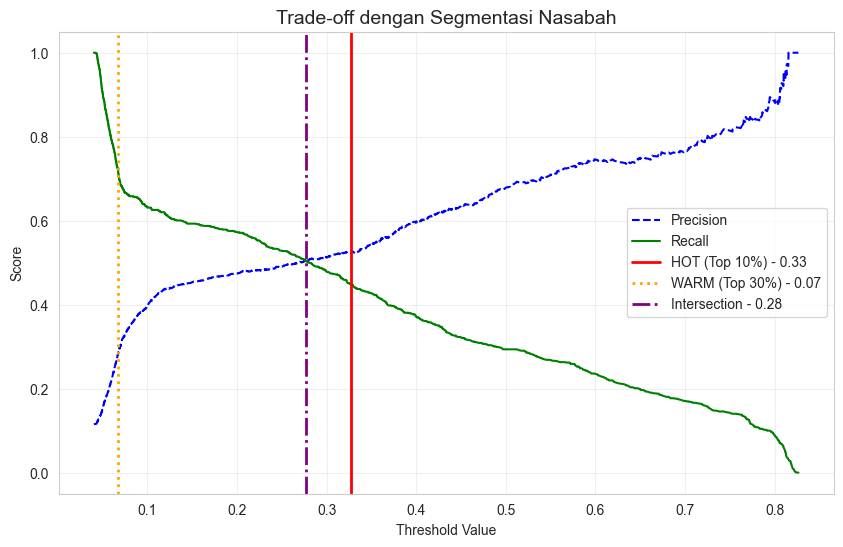

In [9]:
# Prediksi probabilitas pada data test
# Mengambil probabilitas kelas positif (1)
y_probs_test = calibrated_model.predict_proba(X_test_prep)[:, 1]

# Hitung Precision-Recall Curve untuk keperluan plotting dan Intersection
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_test)

# 1. Hot Lead (Top 10% Nasabah dengan probabilitas tertinggi)
t_hot = np.percentile(y_probs_test, 90)

# 2. Warm Lead (Top 30% Nasabah)
t_warm = np.percentile(y_probs_test, 70)

# 3. Intersection (Balance)
diff = np.abs(precisions[:-1] - recalls[:-1])
idx_int = np.argmin(diff)
t_int = thresholds[idx_int]

# Output Threshold
print(f"3 OPSI THRESHOLD (SEGMENTASI & BALANCE)")
print(f"1. HOT Leads (Top 10%)  -> Threshold: {t_hot:.4f} (Prioritas Utama)")
print(f"2. WARM Leads (Top 30%) -> Threshold: {t_warm:.4f} (Prioritas Kedua)")
print(f"3. Intersection (Balance)  -> Threshold: {t_int:.4f} (Titik temu Presisi & Recall)")

# Visualisasi Precision-Recall Tradeoff
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

# Plot garis vertikal
plt.axvline(t_hot, color='red', linestyle='-', linewidth=2, label=f'HOT (Top 10%) - {t_hot:.2f}')
plt.axvline(t_warm, color='orange', linestyle=':', linewidth=2, label=f'WARM (Top 30%) - {t_warm:.2f}')
plt.axvline(t_int, color='purple', linestyle='-.', linewidth=2, label=f'Intersection - {t_int:.2f}')

plt.title('Trade-off dengan Segmentasi Nasabah', fontsize=14)
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Evaluasi Performa Model
Selain metrik untuk kapasitas bisnis, diperlukan juga evaluasi metrik teknis untuk memastikan kualitas model stabil dan valid.

Berikut ini akan ditampilkan:
**ROC Curve** untuk melihat seberapa baik model memisahkan kelas positif dan negatif.

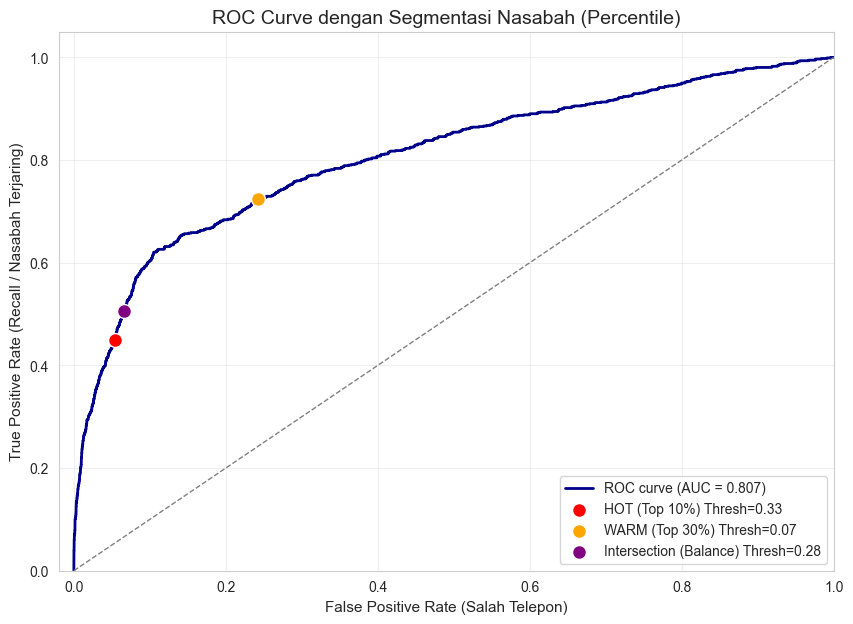

In [10]:
# Hitung False Positive Rate (FPR) dan True Positive Rate (TPR)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs_test)
roc_auc = auc(fpr, tpr)

# Fungsi helper
# Fungsi ini mencari koordinat (FPR, TPR) terdekat yang berasosiasi dengan threshold strategi kami (Hot/Warm/Int)
def find_roc_coords(target_threshold, rocc_threshs, fprs, tprs):
    idx = np.argmin(np.abs(rocc_threshs - target_threshold))
    return fprs[idx], tprs[idx]

# Dapatkan koordinat (x, y) untuk 3 strategi bisnis yang sudah dihitung sebelumnya
fpr_hot, tpr_hot = find_roc_coords(t_hot, roc_thresholds, fpr, tpr)
fpr_warm, tpr_warm = find_roc_coords(t_warm, roc_thresholds, fpr, tpr)
fpr_int, tpr_int = find_roc_coords(t_int, roc_thresholds, fpr, tpr)

# Plotting
plt.figure(figsize=(10, 7))

# Garis utama ROC
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') # Garis random

# Plot titik strategi bisnis (UPDATE LABEL & WARNA)
# HOT Leads (Merah)
# WARM Leads (Oranye)
# Intersection (Ungu)
plt.scatter(fpr_hot, tpr_hot, s=100, c='red', label=f'HOT (Top 10%) Thresh={t_hot:.2f}', zorder=5, edgecolors='white')
plt.scatter(fpr_warm, tpr_warm, s=100, c='orange', label=f'WARM (Top 30%) Thresh={t_warm:.2f}', zorder=5, edgecolors='white')
plt.scatter(fpr_int, tpr_int, s=100, c='purple', label=f'Intersection (Balance) Thresh={t_int:.2f}', zorder=5, edgecolors='white')

# Anotasi dan Label
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Telepon)', fontsize=11)
plt.ylabel('True Positive Rate (Recall / Nasabah Terjaring)', fontsize=11)
plt.title('ROC Curve dengan Segmentasi Nasabah (Percentile)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

## 7. Interpretasi Model (Explainability)
Stakeholder bisnis mungkin bertanya: *"Mengapa model memprediksi nasabah A akan membeli?"* untuk menjawab "Black Box" dari XGBoost, kami menggunakan **SHAP (SHapley Additive exPlanations)**. Ini menunjukkan fitur mana yang paling mendorong probabilitas naik (positif) atau turun (negatif).

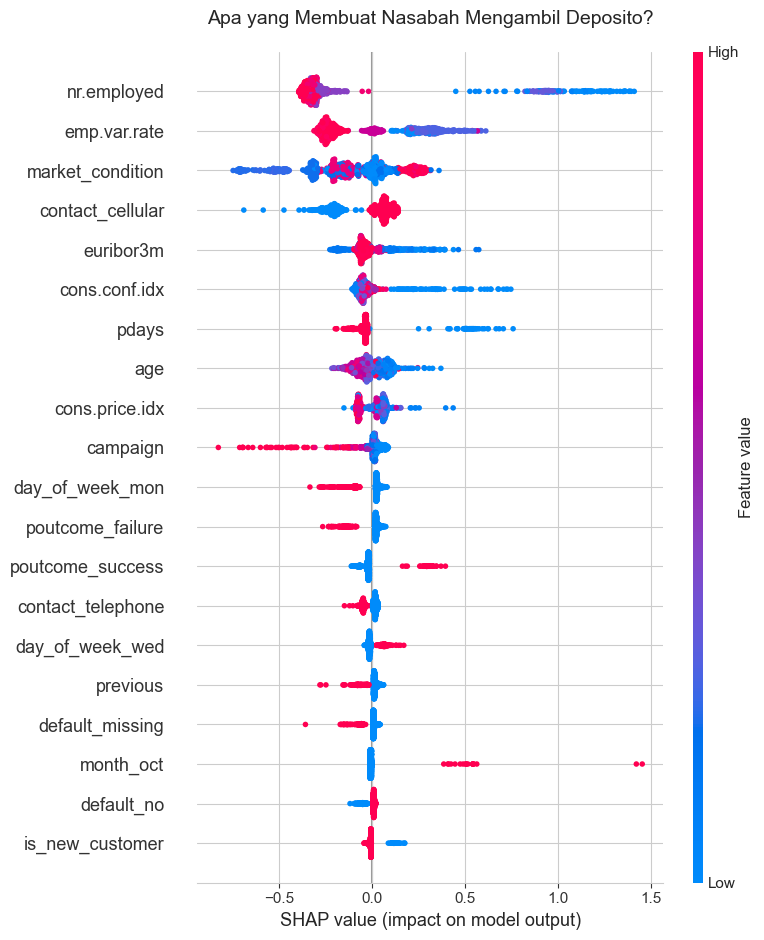

In [11]:
# Melatih ulang XGBoost murni (tanpa wrapper Calibrated) untuk TreeExplainer
# karena CalibratedClassifierCV tidak support SHAP secara langsung.
xgb_explain = XGBClassifier(**best_params)
xgb_explain.fit(X_train_prep, y_train)

explainer = shap.TreeExplainer(xgb_explain)
X_shap = X_test_prep[:1000]  # Ambil sampel 1000 data agar visualisasi cepat dan rapi
shap_values = explainer.shap_values(X_shap)

plt.figure(figsize=(10, 8))
plt.title("Apa yang Membuat Nasabah Mengambil Deposito?", fontsize=14, pad=20)
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

## 8. Evaluasi Dampak Operasional: Analisis Confusion Matrix

Visualisasi *Confusion Matrix* di bawah ini memetakan konsekuensi nyata dari setiap pilihan strategi terhadap operasional bank. Akan terlihat pergeseran *trade-off* antara:
1.  **True Positive (Hit):** Nasabah potensial yang berhasil dihubungi (Revenue).
2.  **False Positive (Miss/Noise):** Nasabah yang tidak tertarik namun tetap ditelepon (Biaya & Gangguan).

**Fokus Analisis:**
Melihat bagaimana strategi **Hot Leads** secara drastis menekan angka *False Positive* (menghemat biaya telepon), sementara strategi **Warm Leads** meningkatkan *True Positive* (menambah nasabah) namun dengan konsekuensi kenaikan biaya operasional.

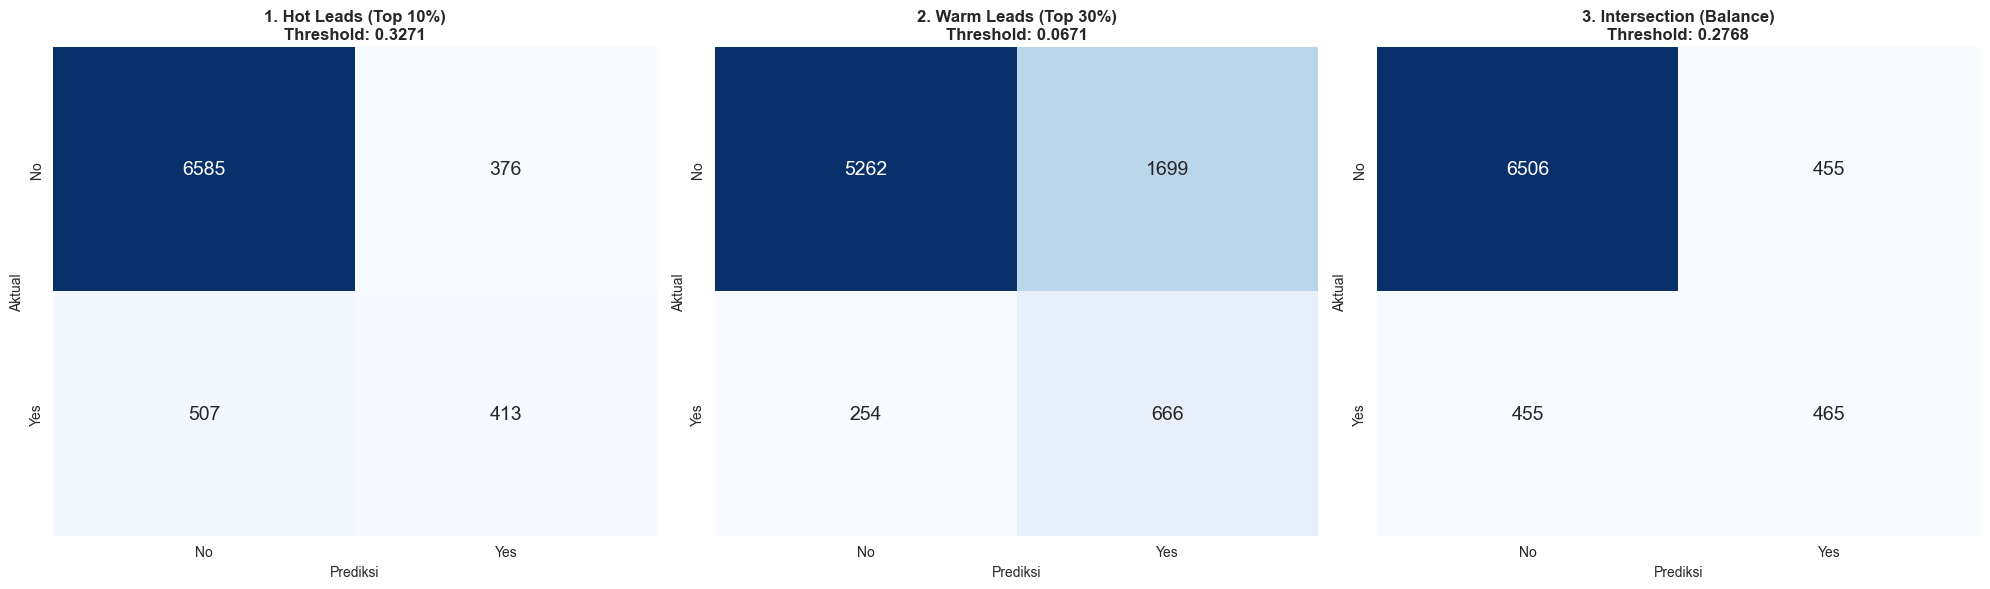

1. Hot Leads (Top 10%) (Threshold: 0.3271)

              precision    recall  f1-score   support

          No       0.93      0.95      0.94      6961
         Yes       0.52      0.45      0.48       920

    accuracy                           0.89      7881
   macro avg       0.73      0.70      0.71      7881
weighted avg       0.88      0.89      0.88      7881

2. Warm Leads (Top 30%) (Threshold: 0.0671)

              precision    recall  f1-score   support

          No       0.95      0.76      0.84      6961
         Yes       0.28      0.72      0.41       920

    accuracy                           0.75      7881
   macro avg       0.62      0.74      0.62      7881
weighted avg       0.88      0.75      0.79      7881

3. Intersection (Balance) (Threshold: 0.2768)

              precision    recall  f1-score   support

          No       0.93      0.93      0.93      6961
         Yes       0.51      0.51      0.51       920

    accuracy                           0.88   

In [12]:
# Menggunakan subplot untuk membandingkan 3 skenario secara berdampingan
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Mendefinisikan strategi berdasarkan threshold yang telah dihitung sebelumnya
strategies = [
    ("1. Hot Leads (Top 10%)", t_hot),       # High Precision / Cost Efficiency
    ("2. Warm Leads (Top 30%)", t_warm),     # Volume Expansion
    ("3. Intersection (Balance)", t_int)     # Technical Equilibrium
]

for i, (name, thresh) in enumerate(strategies):
    # Membuat prediksi biner berdasarkan threshold spesifik
    y_pred_temp = (y_probs_test >= thresh).astype(int)
    # Menghitung Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_temp)
    # Plotting Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
    # Styling
    axes[i].set_title(f'{name}\nThreshold: {thresh:.4f}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prediksi', fontsize=10)
    axes[i].set_ylabel('Aktual', fontsize=10)
    axes[i].set_xticklabels(['No', 'Yes'])
    axes[i].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# Print Classification Report untuk detail angka
for name, thresh in strategies:
    print(f"{name} (Threshold: {thresh:.4f})\n")
    y_pred_strategy = (y_probs_test >= thresh).astype(int)
    print(classification_report(y_test, y_pred_strategy, target_names=['No', 'Yes']))

## 9. Simulasi Profit: Analisis Cost-Benefit
Kami tidak hanya berhenti pada F1-Score atau ROC-AUC, untuk kepentingan bisnis kami perlu memperhitungkan juga dampak finansialnya.

**Masalah:** F1-Score tinggi tidak selalu berarti profit maksimal.

**Solusi:** Kami akan mensimulasikan total keuntungan berdasarkan *threshold* keputusan yang berbeda.

**Asumsi Bisnis (Dapat Disesuaikan):**
* **Biaya Telepon (Cost):** $1 per panggilan (mencakup pulsa & waktu agen).
* **Keuntungan (Benefit):** $10 jika nasabah membuka deposito.

**Rumus Profit:**
$$\text{Profit} = (\text{True Positive} \times \$10) - ((\text{True Positive} + \text{False Positive}) \times \$1)$$

* *Revenue* didapat hanya dari nasabah yang ditelepon dan setuju (TP).
* *Cost* dikeluarkan untuk semua nasabah yang ditelepon (TP + FP).

Skenario Terbaik:
Threshold Optimal : 0.0900
Estimasi Profit   : $4,419


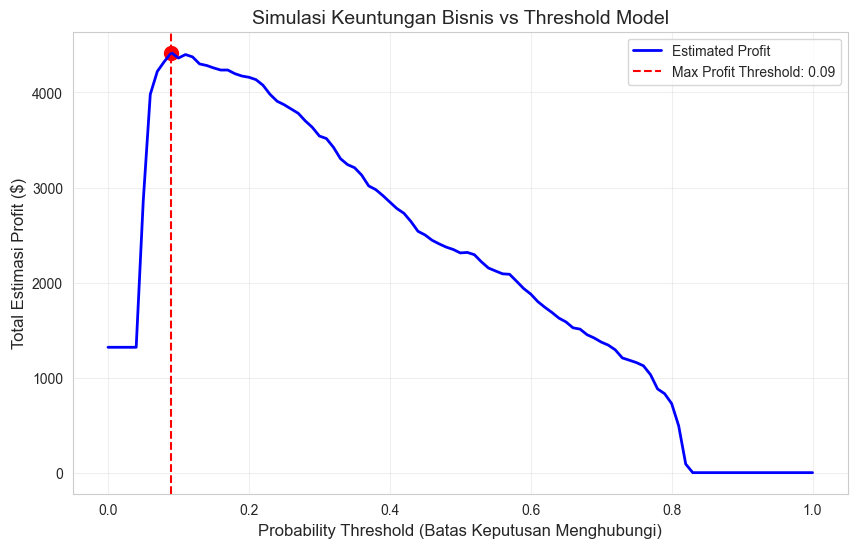

In [13]:
# Profit Simulation Logic
# Definisikan Variabel Bisnis
call_cost = 1 # Biaya per panggilan
deposit_profit = 10 # Keuntungan bersih per deposito berhasil

# Dapatkan Probabilitas Prediksi dari data Test
# Menggunakan probabilitas kelas positif (indeks 1)
y_probs = calibrated_model.predict_proba(X_test_prep)[:, 1]

# Iterasi Berbagai Threshold
thresholds = np.linspace(0, 1, 101) # Coba threshold dari 0% sampai 100%
profits = []

for t in thresholds:
    # Jika probabilitas >= t, maka prediksi 1 (Hubungi), jika tidak 0 (Jangan Hubungi)
    y_pred_t = (y_probs >= t).astype(int)

    # Hitung TP dan FP
    tp = np.sum((y_test == 1) & (y_pred_t == 1)) # Berhasil Deposito
    fp = np.sum((y_test == 0) & (y_pred_t == 1)) # Gagal Deposito (Biaya terbuang)

    # Hitung Profit
    # Revenue = TP * 10
    # Expense = (TP + FP) * 1 (Biaya telepon untuk semua yang dihubungi)
    net_profit = (tp * deposit_profit) - ((tp + fp) * call_cost)
    profits.append(net_profit)

# Cari Threshold Optimal
max_profit = max(profits)
best_threshold_idx = np.argmax(profits)
best_threshold = thresholds[best_threshold_idx]

# Visualisasi Profit Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, color='blue', linewidth=2, label='Estimated Profit')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Max Profit Threshold: {best_threshold:.2f}')
plt.scatter(best_threshold, max_profit, color='red', s=100)

# Anotasi
plt.title('Simulasi Keuntungan Bisnis vs Threshold Model', fontsize=14)
plt.xlabel('Probability Threshold (Batas Keputusan Menghubungi)', fontsize=12)
plt.ylabel('Total Estimasi Profit ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

print(f"Skenario Terbaik:")
print(f"Threshold Optimal : {best_threshold:.4f}")
print(f"Estimasi Profit   : ${max_profit:,.0f}")
plt.show()

Sehingga metode ini dapat kami gunakan untuk mencari/menentukan batas untuk memberikan profit maksimal yang dapat diperoleh pihak bank.

*Catatan: Karena ini menggunakan asumsi sebagai contoh, kami tidak memasukkannya ke dalam produksi.*

## 10. Final Pipeline & Deployment

Terakhir, kami menggabungkan `Preprocessing` dan `Model` menjadi satu objek Pipeline utuh dan menyimpannya ke file `.pkl`. File ini siap digunakan oleh tim Backend untuk memprediksi data nasabah baru di masa depan. Menggabungkan output prediksi ini ke CSV baru bertujuan untuk mempermudah tim Backend untuk menaruh di databasenya agar dapat memberikan contoh tampilan dashboard yang memperlihatkan setiap nasabah yang sudah diurutkan berdasarkan score dan labelnya.

In [14]:
# Menggabungkan langkah preprocessing dan model yang sudah dikalibrasi
# Input Data Mentah -> Output Probabilitas (Tanpa preprocessing manual lagi)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('model', calibrated_model)
])

try:
    # Tes Validasi Pipeline
    # Tes prediksi dummy untuk memastikan pipeline berjalan
    demo_pred = final_pipeline.predict_proba(X_test.head())[:, 1]
    print("Tes Pipeline Berhasil. Contoh Output Probabilitas:")
    print(demo_pred)
    
    # Simpan model
    filename = 'model_deposito_siap_pakai.pkl'
    joblib.dump(final_pipeline, filename)
    
    print(f"\nModel berhasil disimpan sebagai '{filename}'")
    
except Exception as e:
    print("Ada error saat menggabungkan pipeline:", e)

Tes Pipeline Berhasil. Contoh Output Probabilitas:
[0.05075862 0.08726791 0.06121456 0.05805906 0.04323467]

Model berhasil disimpan sebagai 'model_deposito_siap_pakai.pkl'


In [15]:
# Penerapan Model pada Seluruh Database Nasabah
# Ambil kembali seluruh data fitur (X) tanpa label
X = df.drop(columns='y')

# Lakukan Preprocessing pada seluruh data X
# Menggunakan pipeline yang sudah di-fit sebelumnya
X_prep = preprocessing_pipeline.transform(X)

# Prediksi probabilitas untuk semua data
all_probs = calibrated_model.predict_proba(X_prep)[:, 1]

# Masukkan ke DataFrame asli
df_final = df.copy()
df_final['score'] = all_probs

# Beri Label Kategori (Menggunakan Threshold Sebelumnya)
def categorize(x):
    if x >= t_hot: return 'Hot' # HIGH_PRIORITY
    elif x >= t_warm: return 'Warm' # MEDIUM_PRIORITY
    else: return 'Cold' # STANDARD_PRIORITY

df_final['label_code'] = df_final['score'].apply(categorize)

# Simpan sebagai CSV
df_final.to_csv('bank_data_scored.csv', index=False)

# Menampilkan hasil
print("File 'bank_data_scored.csv' berhasil dibuat.")
df_final[['age','score', 'label_code']].head()

File 'bank_data_scored.csv' berhasil dibuat.


,age,score,label_code
0,56,0.043728,Cold
1,57,0.043581,Cold
2,37,0.043572,Cold
3,40,0.043623,Cold
4,56,0.044625,Cold


# Kesimpulan & Rekomendasi Strategis

## Ringkasan Eksekutif
Proyek ini berhasil mengembangkan *End-to-End Machine Learning Framework* untuk mengoptimalkan kampanye telemarketing perbankan. Menggunakan algoritma **XGBoost** yang dioptimasi dengan **Optuna** dan dikalibrasi probabilitasnya, model ini menawarkan solusi konkret atas inefisiensi biaya operasional dan rendahnya *conversion rate* pada kampanye sebelumnya.

### Pencapaian Kunci (*Key Takeaways*):

1.  **Transformasi Data Berbasis Domain:**
    Implementasi `BankFeatureEngineer` berhasil menangkap sinyal ekonomi makro (interaksi suku bunga & kepercayaan konsumen) serta perilaku nasabah, membuktikan bahwa pemahaman konteks bisnis (*Domain Knowledge*) sama pentingnya dengan pemilihan algoritma.

2.  **Keunggulan Model Terkalibrasi:**
    Penggunaan `CalibratedClassifierCV` memungkinkan model menghasilkan probabilitas yang merefleksikan peluang dunia nyata. Hal ini krusial untuk perhitungan risiko finansial, bukan sekadar prediksi label biner semata.

3.  **Pergeseran Paradigma Evaluasi:**
    Beralih dari metrik teknis murni (Accuracy/F1) menuju **Profit-Oriented Evaluation**. Simulasi membuktikan bahwa mengejar *Recall* 100% justru merugikan secara finansial karena tingginya biaya telepon ke nasabah yang salah (*False Positives*).

---

## Catatan Akademik & Batasan Metodologi (*Critical Review*)

Mengacu pada literatur referensi **Moro et al. (2014)**, kami menyadari adanya tantangan validasi yang bersifat temporal:

* **Pentingnya Konsep *Rolling Window*:**
    Data perbankan dan ekonomi makro memiliki sifat *time-dependent*. Secara ideal, validasi model harus menggunakan skema **Rolling Window** (melatih model pada data masa lalu dan menguji pada masa depan) untuk mensimulasikan kondisi ekonomi yang dinamis.
* **Keputusan Metodologi Saat Ini:**
    Dalam iterasi ini, kami memprioritaskan stabilitas metrik akurasi (*Precision/Recall*) sebagai kriteria utama keberhasilan proyek. Penerapan skema waktu yang ketat (*strict time-series split*) seringkali menyebabkan fluktuasi akurasi yang signifikan akibat perubahan tren ekonomi yang mendadak. Oleh karena itu, pendekatan saat ini difokuskan pada generalisasi pola nasabah secara global, sementara validasi berbasis waktu (*Rolling Window*) ditempatkan sebagai **area pengembangan prioritas** untuk fase selanjutnya guna menjamin ketahanan model jangka panjang.

---

## Rekomendasi Bisnis (*Action Plan*)

Berdasarkan analisis segmentasi **Hot/Warm Leads**, kami merekomendasikan strategi operasional bertingkat:

| Segmen Nasabah | Kriteria (Probabilitas) | Strategi Kontak | Alokasi Sumber Daya |
| :--- | :--- | :--- | :--- |
| **HOT LEADS** | **Top 10%** (> Threshold 1) | **Prioritas Utama (Call)** | Gunakan agen *Senior/Top Performer*. Lakukan pendekatan personal dan intensif. |
| **WARM LEADS** | **Top 11-30%** (> Threshold 2) | **Prioritas Kedua (Call)** | Gunakan agen *Junior/General*. Hubungi jika kapasitas masih tersedia setelah Hot Leads selesai. |
| **COLD LEADS** | **Bawah 70%** | **Do Not Call / Low Cost** | **Jangan ditelepon** (biaya > potensi profit). Alihkan ke kanal murah seperti *Email Marketing* atau *SMS Blast*. |

## Rencana Implementasi Selanjutnya (*Future Works*)

Untuk meningkatkan dampak bisnis dan validitas teknis di masa depan, kami menyarankan untuk:
1.  **Implementasi Rolling Window Validation:** Menguji ketahanan model terhadap perubahan waktu dengan melatih ulang model secara periodik mengikuti data terbaru.
2.  **Feedback Loop:** Menyimpan data hasil telepon terbaru untuk melatih ulang (*retrain*) model secara berkala, agar model adaptif terhadap perubahan tren ekonomi.
3.  **Deployment Real-time:** Mengintegrasikan model `.pkl` ke dalam sistem CRM agar *scoring* nasabah terjadi seketika saat data nasabah baru masuk.

---
*Dokumen ini disusun sebagai bagian dari Capstone Project kami. Seluruh kode, model, dan hasil prediksi telah diserialisasi untuk dilanjutkan ke tahap produksi.*